In [21]:
import numpy as np
import pykitti
import open3d as o3d

# 读取数据集

In [22]:
# 读取数据集
basedir = 'datasets'
date = '2011_10_03'
drive = '0027'
dataset = pykitti.raw(basedir, date, drive)

In [23]:
# 读取点云数据
data = dataset.get_velo(0)
print('origin data shape: ', data.shape) # x, y, z, reflectance
# 创建一个空的点云对象
point_cloud = o3d.geometry.PointCloud()
# 将 xyz 数据填充到点云中
point_cloud.points = o3d.utility.Vector3dVector(data[:, :3])
print(point_cloud)
print('point cloud shape: ', np.asarray(point_cloud.points).shape)

origin data shape:  (124668, 4)
PointCloud with 124668 points.
point cloud shape:  (124668, 3)


# 基本操作

In [24]:
# o3d可视化原始点云（适用于大点云，没有坐标）
# o3d.visualization.draw_geometries([point_cloud])

In [25]:
# 进行体素下采样
voxel_size = 2.0  # 体素大小，根据需要调整
downsampled_point_cloud = point_cloud.voxel_down_sample(voxel_size)
print('downsampled point cloud shape: ', np.asarray(downsampled_point_cloud.points).shape)
# 可视化降采样后的点云
# o3d.visualization.draw_geometries([downsampled_point_cloud])

downsampled point cloud shape:  (1616, 3)


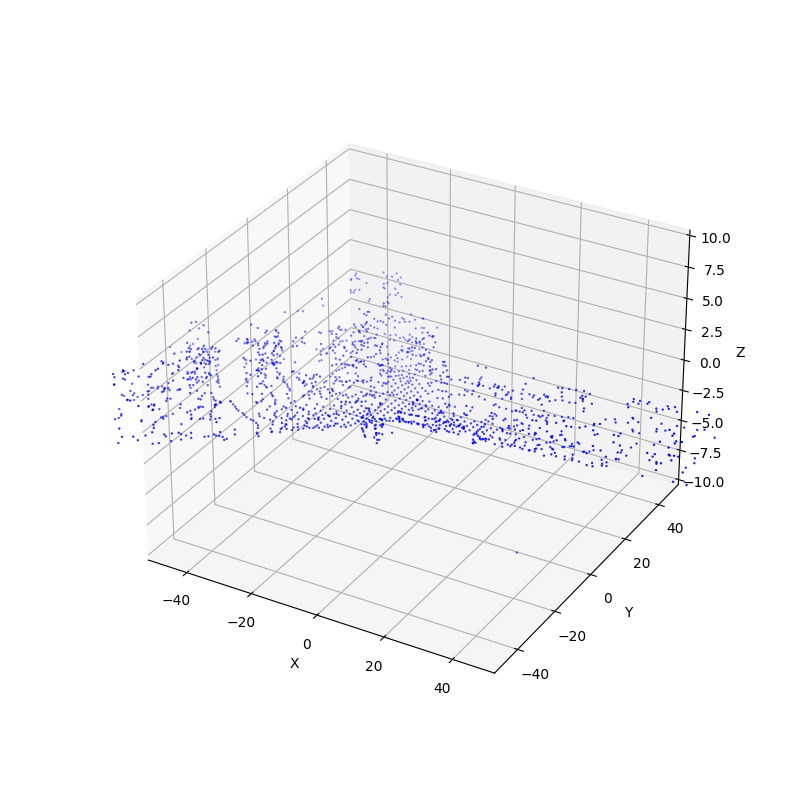

In [26]:
%matplotlib widget
# matplotlib可视化原始点云（适用于小点云，有坐标）
import matplotlib.pyplot as plt
def draw_numpy_point_cloud(ax, pc, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None, color='blue'):
    ax.scatter(pc[:, axes[0]], pc[:, axes[1]], pc[:, axes[2]], s=0.5, c=color)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

downsampled_point_cloud_np = np.asarray(downsampled_point_cloud.points)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
draw_numpy_point_cloud(ax, downsampled_point_cloud_np, xlim3d=[-50, 50], ylim3d=[-50, 50], zlim3d=[-10, 10])

Transformation Matrix: 
 [[ 1. -1.  0. 30.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


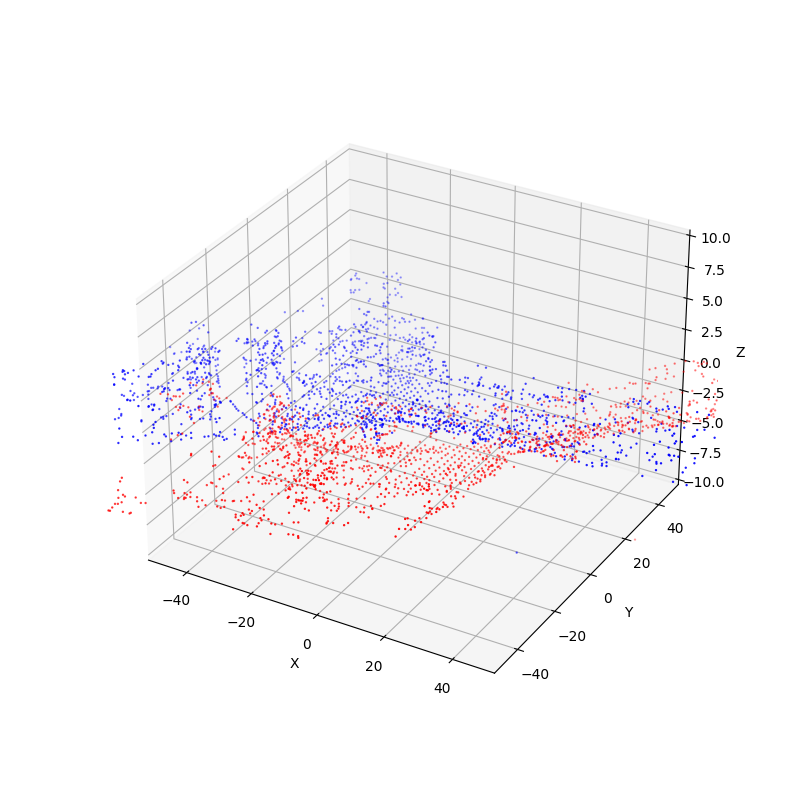

In [27]:

import copy
# 变换点云坐标系
R = np.array([[1, -1, 0],
              [1, 0, 0],
              [0, 0, 1]])
# 沿着 X 轴平移 10 个单位
t = np.array([30, 0, 0])
# 变换矩阵
T = np.eye(4)
T[:3, :3] = R
T[:3, 3] = t
print('Transformation Matrix: \n', T)
# 变换点云
transformed_point_cloud = copy.deepcopy(point_cloud.voxel_down_sample(voxel_size)).transform(T)
# 对比变换前后的点云
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
draw_numpy_point_cloud(ax, downsampled_point_cloud_np, xlim3d=[-50, 50], ylim3d=[-50, 50], zlim3d=[-10, 10], color='blue')
draw_numpy_point_cloud(ax, np.asarray(transformed_point_cloud.points), xlim3d=[-50, 50], ylim3d=[-50, 50], zlim3d=[-10, 10], color='red')

# ICP配准

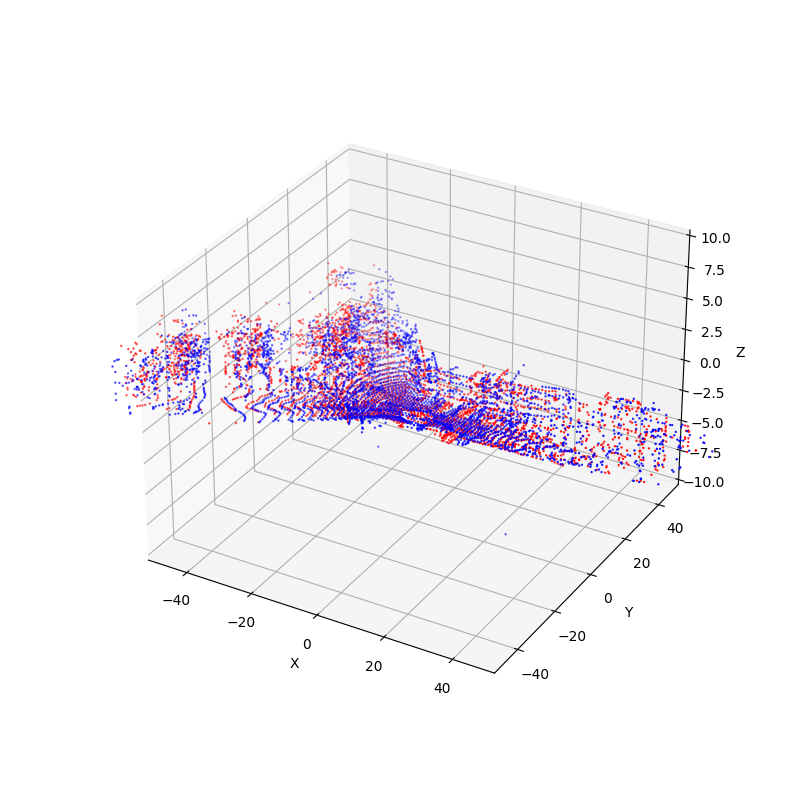

In [28]:
data1 = dataset.get_velo(5)
data2 = dataset.get_velo(10)
point_cloud1 = o3d.geometry.PointCloud()
point_cloud1.points = o3d.utility.Vector3dVector(data1[:, :3])
point_cloud2 = o3d.geometry.PointCloud()
point_cloud2.points = o3d.utility.Vector3dVector(data2[:, :3])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
draw_numpy_point_cloud(ax, np.asarray(point_cloud1.voxel_down_sample(1.0).points), xlim3d=[-50, 50], ylim3d=[-50, 50], zlim3d=[-10, 10], color='blue')
draw_numpy_point_cloud(ax, np.asarray(point_cloud2.voxel_down_sample(1.0).points), xlim3d=[-50, 50], ylim3d=[-50, 50], zlim3d=[-10, 10], color='red')

In [29]:
# o3d可视化点云配准结果
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

In [30]:
T = np.eye(4)
t = np.array([0, 0, 0])
T[:3, 3] = t
draw_registration_result(point_cloud1, point_cloud2, T)

In [31]:
# ICP配准
reg_p2p = o3d.pipelines.registration.registration_icp(
    point_cloud1, point_cloud2, 0.5, np.identity(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(point_cloud1, point_cloud2, reg_p2p.transformation)

RegistrationResult with fitness=7.021320e-01, inlier_rmse=1.853009e-01, and correspondence_set size of 87011
Access transformation to get result.
Transformation is:
[[ 9.99710401e-01  2.32479238e-02 -6.21670609e-03 -7.19576667e-02]
 [-2.32521294e-02  9.99729450e-01 -6.05066136e-04  9.00456505e-02]
 [ 6.20095763e-03  7.49442563e-04  9.99980493e-01 -4.05565185e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


# 滤除地面

In [32]:
# 滤除地面点(z<0.1)
ground_filter1 = np.asarray(point_cloud1.points)
ground_filter1 = ground_filter1[ground_filter1[:, 2] > 0.1]
ground_filter1 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ground_filter1))
print('ground_filter1 shape: ', np.asarray(ground_filter1.points).shape)
ground_filter2 = np.asarray(point_cloud2.points)
ground_filter2 = ground_filter2[ground_filter2[:, 2] > 0.1]
ground_filter2 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ground_filter2))
print('ground_filter2 shape: ', np.asarray(ground_filter2.points).shape)
# 可视化滤除地面点后的点云
T = np.eye(4)
t = np.array([0, 0, 0])
T[:3, 3] = t
draw_registration_result(ground_filter1, ground_filter2, T)

ground_filter1 shape:  (14622, 3)
ground_filter2 shape:  (14932, 3)


In [33]:
# 去中心化
ground_filter1 = np.asarray(ground_filter1.points)
ground_filter2 = np.asarray(ground_filter2.points)
ground_filter1 -= np.mean(ground_filter1, axis=0)
ground_filter2 -= np.mean(ground_filter2, axis=0)
# 转回o3d格式
ground_filter1 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ground_filter1))
ground_filter2 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ground_filter2))

In [34]:
# ICP配准
reg_p2p = o3d.pipelines.registration.registration_icp(
    ground_filter1, ground_filter2, 0.5, np.identity(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(ground_filter1, ground_filter2, reg_p2p.transformation)

RegistrationResult with fitness=4.831760e-01, inlier_rmse=1.868882e-01, and correspondence_set size of 7065
Access transformation to get result.
Transformation is:
[[ 9.99734892e-01  2.29916218e-02  1.23729593e-03  7.78757156e-02]
 [-2.29906321e-02  9.99735354e-01 -8.08289564e-04  2.38722321e-01]
 [-1.25555237e-03  7.79629065e-04  9.99998908e-01  2.56619870e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [35]:
# 可视化正确的配准结果
index = np.asarray(reg_p2p.correspondence_set)
idx1 = index[:, 0]
idx2 = index[:, 1]
corresponding_point_cloud1 = ground_filter1.select_by_index(idx1)
corresponding_point_cloud2 = ground_filter2.select_by_index(idx2)
# draw_registration_result(corresponding_point_cloud1, corresponding_point_cloud2, reg_p2p.transformation)
success_rate = len(index) / len(ground_filter1.points)
print('success rate: ', success_rate)

success rate:  0.4831760361099713


# 真值比对

In [36]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def read_data(file_path):
    """
    读取数据文件并返回一个包含所有帧的列表。
    """
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # 忽略时间戳，只读取位置和四元数
            position = np.array(parts[1:4], dtype=float)
            quaternion = np.array(parts[4:], dtype=float)
            R_cam2world = R.from_quat(quaternion).as_matrix()
            # 从相机坐标系转换到雷达坐标系(先绕y轴旋转90度，再绕x轴旋转-90度)
            R1 = R.from_euler('y', 90, degrees=True).as_matrix()
            R2 = R.from_euler('x', -90, degrees=True).as_matrix()
            R_lidar2cam = np.dot(R2, R1)
            R_lidar2world = np.dot(R_cam2world, R_lidar2cam)
            position = np.dot(R_cam2world, position)
            data.append((position, R_lidar2world))
    return data

def compute_transformation_matrix(frame1, frame2):
    """
    计算两帧之间的变换矩阵。
    """
    pos1, rot1 = frame1
    pos2, rot2 = frame2
    
    # 构建变换矩阵
    T1 = np.eye(4)
    T2 = np.eye(4)
    T1[:3, :3] = rot1
    T1[:3, 3] = pos1
    T2[:3, :3] = rot2
    T2[:3, 3] = pos2

    T = np.dot(np.linalg.inv(T1), T2)
    return T

In [37]:
# 读取groundtruth
file_path = './datasets/2011_10_03/2011_10_03_drive_0027_sync/groundtruth.txt'
data = read_data(file_path)
print(data[5][0])
print(data[5][1])
print(data[10][0])
print(data[10][1])

[-0.27906905 -0.1660537   4.287794  ]
[[-0.00258617  0.01033094  0.99994329]
 [-0.99997985  0.00577016 -0.00264588]
 [-0.00579717 -0.99992999  0.01031581]]
[-0.64742218 -0.38033093  8.56751909]
[[-0.00504987  0.02066463  0.99977371]
 [-0.99991945  0.0115373  -0.00528907]
 [-0.01164399 -0.99971989  0.0206047 ]]


In [38]:
# 计算前一帧和后一帧之间的变换矩阵
transformation_matrix = compute_transformation_matrix(data[5], data[10])
print(transformation_matrix)

[[ 9.99979871e-01 -5.79496604e-03  2.58392975e-03  1.90415247e-01]
 [ 5.82130517e-03  9.99929955e-01 -1.03051751e-02 -4.28446730e+00]
 [-2.52403062e-03  1.03200095e-02  9.99943562e-01 -3.23616455e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [39]:
# 使用真实的变换矩阵变换点云
draw_registration_result(ground_filter2, ground_filter1, transformation_matrix)